# Inception(frozen)-LSTM
This model uses seq2seq architecure with teacher forcing to caption images from MS COCO dataset.

Example image from model after training:

![](https://drive.google.com/uc?id=1xdcSs3naEnZc5gzhwQTGPCRx2W11qli0)

Note that attention can be added upon this architecure, but it takes more time to train.

###Importing relevant libraries

In [76]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import json
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
keras = tf.keras

##Setting config parameters

In [2]:
max_cap_len = 15  # Determines max length of captioning sentences
img_dimension = 299 # Determines the height and width of images
num_words = 10000 # Determines vocab size to tokenize and train on
encoding_size = 512 # Determines dimension of the encodings of images
LSTM_size = 512 
batch_size = 128
n_epochs = 15
Buffer_size = 1000
validation_and_test_split = 0.2
test_to_val_split = 0.5
num_examples = None # Determines number of overall read samples. If set to none all samples will be read as long as they don't exceed max_cap_len

##Data Preprocessing


###Downloading the MS COCO dataset

Both this cell and the one below it were copied from a google documentation.

I have done some editing like stripping out most of 'a', 'an' and 'the' words as they had little value and were too common.

Link of the google doucmenatin:

https://www.tensorflow.org/tutorials/text/image_captioning#model

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'

annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'

image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
PATH = os.path.dirname(image_zip) + image_folder
os.remove(image_zip)



13510582272/13510573713 [==============================] - 854s 0us/step


###Reading the data

In [22]:
# Read the json file
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)


In [24]:

# Store captions and image names in vectors
all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = annot['caption']

    #Removing the word 'a' from captions
    caption = caption.replace(" a "," ")
    caption = caption.replace("A ","")
    #Removing the word 'an' from captions
    caption = caption.replace("An ","")
    caption = caption.replace(" an "," ")
    #Removing the word 'the' from captions
    caption = caption.replace(" the "," ")
    caption = caption.replace("The ","")

    #Load only captions that don't exceed maximum length
    if len(caption.split(" ")) > max_cap_len:
      continue
    else:
      caption = '<sos> ' + caption + ' <eos>'
      image_id = annot['image_id']
      full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

      all_img_name_vector.append(full_coco_image_path)
      all_captions.append(caption)
all_img_name_vector = all_img_name_vector[:6000]
all_captions = all_captions[:6000]
# Shuffle captions and image_names together
# Set a random state
train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=42)
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

caption_train, captions_test, img_name_vector_train, img_name_vector_test = train_test_split(train_captions,
                                                                      img_name_vector,
                                                                      test_size= validation_and_test_split)

caption_val, caption_test, img_name_vector_val, img_name_vector_test = train_test_split(captions_test,
                                                        img_name_vector_test,
                                                        test_size= test_to_val_split)
num_samples = len(img_name_vector)
assert len(train_captions) == len(img_name_vector)
print("Loaded %d samples" %(num_samples))
print("Loaded %d train samples" %(len(caption_train)))
print("Loaded %d valid samples" %(len(caption_val)))
print("Loaded %d test samples" %(len(caption_test)))


Loaded 6000 samples
Loaded 4800 train samples
Loaded 600 valid samples
Loaded 600 test samples


###Tokenizing and padding captions

In [25]:
tok = keras.preprocessing.text.Tokenizer(num_words = num_words
                                         ,filters ="!?,'()_-+=&*$#@.",oov_token="<unk>")
tok.fit_on_texts(caption_train)
captions_train = tok.texts_to_sequences(caption_train)
if num_words == None:
  words = len(tok.word_index)
else:
  words = num_words
captions_train = keras.preprocessing.sequence.pad_sequences(captions_train, padding='post',maxlen=max_cap_len + 2)
print("Examlpe:", captions_train[np.random.randint(low=0, high= len(captions_train) - 1,size=1)[0]])
print("Found %d unique words" %(words))

Examlpe: [   2    8  145  394  173   88    6 1583 2554 1454    3    0    0    0
    0    0    0]
Found 10000 unique words


In [26]:
captions_valid = tok.texts_to_sequences(caption_val)
captions_valid = keras.preprocessing.sequence.pad_sequences(captions_valid, padding='post',maxlen=max_cap_len + 2)

###Defining preprocessing functions of dataset
tf.data api is used for making efficient input pipelines as the data is huge for ram.

In [27]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (img_dimension, img_dimension))
  return img

In [28]:
def preprocess_func(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_train,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]
  
  h_and_c_init = tf.zeros((LSTM_size))
   
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [29]:
def preprocess_func_val(path_index, caption):
  #Reading the image
  path_index = tf.reshape(path_index, ())
  path = tf.gather(img_name_vector_val,indices=path_index)
  img = load_img(path)#/255.0
  #Preprocessing text
  teacher_caption = caption[:-1]
  tar_caption = caption[1:]

  h_and_c_init = tf.zeros((LSTM_size))
  
  return (img,h_and_c_init,teacher_caption), tar_caption 

In [30]:
#Creating an array to index each img path for reading 
path_index_vec_train = np.array(list(range(0,len(img_name_vector_train)))).reshape(-1,1)
path_index_vec_val = np.array(list(range(0,len(img_name_vector_val)))).reshape(-1,1)

dataset1_train = tf.data.Dataset.from_tensor_slices(path_index_vec_train)
dataset2_train = tf.data.Dataset.from_tensor_slices(captions_train)
dataset = tf.data.Dataset.zip((dataset1_train,dataset2_train))
dataset = dataset.map(preprocess_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset1_val = tf.data.Dataset.from_tensor_slices(path_index_vec_val)
dataset2_val = tf.data.Dataset.from_tensor_slices(captions_valid)
dataset_val = tf.data.Dataset.zip((dataset1_val,dataset2_val))
dataset_val = dataset_val.map(preprocess_func_val, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [31]:
dataset = dataset.shuffle(Buffer_size).batch(batch_size,drop_remainder=True).prefetch(1)
dataset_val = dataset_val.shuffle(Buffer_size).batch(256,drop_remainder=True).prefetch(1)

##Building the model

###Downloading Inception and freezing it.

In [32]:
from keras.applications.inception_v3 import preprocess_input


incep = keras.applications.inception_v3.InceptionV3(input_shape=(img_dimension,img_dimension,3),
                                                    include_top=False)
incep.trainable=False
incep.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

In [33]:
encoder = keras.models.Sequential([
                                   keras.layers.Lambda(preprocess_input,input_shape=(img_dimension,img_dimension,3),name="preprocessing_layer"),
                                   incep,
                                   keras.layers.Dense(encoding_size,activation='relu',name="encoding_layer"),
                                   keras.layers.Reshape((8*8,encoding_size),name="reshape_layer")
],name="Encoder")
encoder.summary()

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing_layer (Lambda) (None, 299, 299, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
encoding_layer (Dense)       (None, 8, 8, 512)         1049088   
_________________________________________________________________
reshape_layer (Reshape)      (None, 64, 512)           0         
Total params: 22,851,872
Trainable params: 1,049,088
Non-trainable params: 21,802,784
_________________________________________________________________


###Completing the model

####Building attention mechanism
This is Bahdanau attention, A soft attention mechanism that works through linear combination of previous state and the whole image.

In [34]:
W1 = keras.layers.Dense(512,name="W1")
W2 = keras.layers.Dense(512,name="W2")
V = keras.layers.Dense(1,name="V")
repeater = keras.layers.RepeatVector(8*8)
doter = keras.layers.Dot(axes=1)
concatenator = keras.layers.Concatenate()

def attention_step(enc,h_prev):
  h = repeater(h_prev)
  score = tf.nn.tanh(W1(enc)+ W2(h))

  alphas =tf.nn.softmax(V(score),axis=1)

  context = doter([alphas,enc])
  return context

####Building the deoder

This decoder goes one time-step at a time.

So, a custom training function is required.

In [35]:
encodings = keras.layers.Input(shape=(8*8,encoding_size))

init_h = keras.layers.Input(shape=(LSTM_size))
init_c = keras.layers.Input(shape=(LSTM_size))

teacher_forcing = keras.layers.Input(shape=(1))

embedding_layer = keras.layers.Embedding(words+1,256,)


context_prev_tar_concat_layer = keras.layers.Concatenate()
decoder_lstm_layer = keras.layers.LSTM(LSTM_size,return_state=True,dropout=0.2)
decoder_dense_layer = keras.layers.Dense(words+1,activation='softmax')

h = init_h

c = init_c

context = attention_step(encodings,h)

embedds = embedding_layer(teacher_forcing)

decoder_lstm_input = context_prev_tar_concat_layer([context,embedds])
  
h , _ , c = decoder_lstm_layer(decoder_lstm_input,initial_state=[h,c])
  
out = decoder_dense_layer(h)

decoder = keras.models.Model([encodings,init_h,init_c,teacher_forcing],[out,h,c])
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 64, 512)]    0                                            
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 64, 512)      0           input_8[0][0]                    
__________________________________________________________________________________________________
W1 (Dense)                      (None, 64, 512)      262656      input_7[0][0]                    
____________________________________________________________________________________________

##Defining custom loss function
This loss function masks the padded steps and also one-hot enodes the targets

In [36]:
def sparse_it_up(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))

  real = tf.cast(real,tf.int64)
  real = tf.one_hot(real,words+1,axis=-1)

  loss_ = tf.losses.categorical_crossentropy(real, pred)

  mask = tf.cast(mask, dtype=tf.float32)

  loss_ *= mask

  return tf.reduce_mean(loss_)


##Defining the custom train loop

This custorm training loop was inspired from the google documentation linked above aswell.

In [37]:
optimizer = keras.optimizers.Adam()

@tf.function
def train_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss


In [38]:
'''This function is for forward passing features for calculating losses with no backprop'''
@tf.function
def valid_step(img,init_state,teacher,target):
  with tf.GradientTape() as tape:

    encodings = encoder(img)
    h = init_state
    c = init_state
    loss = 0
    for i in range(max_cap_len+1):
      dec_inp = teacher[:,i:i+1]
      o, h , c = decoder([encodings,h,c,dec_inp])

      loss += sparse_it_up(target[:,i],o) 

  return loss

##Training the model
One training epoch takes about 35 minutes on google colab with gpu.

So, get busy doing something else for a while! or just go for a smaller num_examples set from the configuration cell.

In [39]:
import time

In [42]:
EPOCHS = 10

prev_loss = np.inf

for epoch in range(EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, ((img, s, teacher) ,target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img, s, teacher ,target)
        total_loss += t_loss

        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    
    val_loss=0

    for (i, ((img, s, teacher) ,target)) in enumerate(dataset_val):
      val_loss += valid_step(img, s, teacher ,target)
    
    val_loss = val_loss.numpy()/((i+1)*(max_cap_len+1))
    print("val_loss=",val_loss)
    
    #This code makes sure we only save the best val_loss score weights
    if val_loss < prev_loss:
      print("Model_imporved. Saving..")

      encoder.save("encoder.hdf5")
      decoder.save("decoder.hdf5")
    
    else:
      print("Model didn't imporve.")

    prev_loss = val_loss




Epoch 1 Batch 0 Loss 2.9121
val_loss= 2.9687840938568115
Model_imporved. Saving..
Epoch 2 Batch 0 Loss 2.8200
val_loss= 2.7918190956115723
Model_imporved. Saving..
Epoch 3 Batch 0 Loss 2.7317
val_loss= 2.6892337799072266
Model_imporved. Saving..
Epoch 4 Batch 0 Loss 2.6076
val_loss= 2.5700316429138184
Model_imporved. Saving..
Epoch 5 Batch 0 Loss 2.5206
val_loss= 2.5038437843322754
Model_imporved. Saving..
Epoch 6 Batch 0 Loss 2.3530
val_loss= 2.4670662879943848
Model_imporved. Saving..
Epoch 7 Batch 0 Loss 1.9941
val_loss= 2.4108569622039795
Model_imporved. Saving..
Epoch 8 Batch 0 Loss 1.9863
val_loss= 2.404913902282715
Model_imporved. Saving..
Epoch 9 Batch 0 Loss 1.9311
val_loss= 2.3544182777404785
Model_imporved. Saving..
Epoch 10 Batch 0 Loss 1.9972
val_loss= 2.327887773513794
Model_imporved. Saving..


In [41]:
new_input = incep.input
hidden_layer = incep.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
smoothing = SmoothingFunction()
def evaluate_bleu(image, captions):

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()

        if tokenizer.index_word[predicted_id] == '<end>':
            break
        result.append(tokenizer.index_word[predicted_id])
        dec_input = tf.expand_dims([predicted_id], 0)

    bleu_score = sentence_bleu(tokenizer.sequences_to_texts(captions), result, smoothing_function=smoothing.method1)

    
    return bleu_score

In [ ]:
# Loading the best validation accuracy score weights
encoder.load_weights("encoder.hdf5")
decoder.load_weights("decoder.hdf5")

##Prediction function
This function takes its input as path of an image and captions it

In [60]:
def caption_image(path):
  image = load_img(path)#/255.0
  encodings = encoder.predict(tf.reshape(image,(1,img_dimension,img_dimension,3)))
  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = np.zeros((1,LSTM_size))
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1])).reshape(1,-1)
    #print(dec_inp)
    props,h,c = decoder.predict([encodings,h,c ,dec_inp])
    props= props[0]
    idx = np.argmax(props)
    texts.append(tok.index_word.get(idx))
    if idx == tok.word_index['<eos>']:
      break
  if tok.word_index.get(texts[-1]) != tok.word_index['<eos>']:
    texts.append('<eos>')

  print(texts)
  print(' '.join(texts))
  plt.imshow(image/255.0)
  plt.axis("off")

In [72]:
def calculate_bleu(path, caption):
  image = load_img(path)#/255.0
  encodings = encoder.predict(tf.reshape(image,(1,img_dimension,img_dimension,3)))
  texts = ["<sos>"]
  h = np.zeros((1,LSTM_size))
  c = np.zeros((1,LSTM_size))
  for _ in range(max_cap_len + 1):
    dec_inp = np.array(tok.word_index.get(texts[-1])).reshape(1,-1)
    #print(dec_inp)
    props,h,c = decoder.predict([encodings,h,c ,dec_inp])
    props= props[0]
    idx = np.argmax(props)
    texts.append(tok.index_word.get(idx))
    if idx == tok.word_index['<eos>']:
      break
  if tok.word_index.get(texts[-1]) != tok.word_index['<eos>']:
    texts.append('<eos>')
  bleu_score = sentence_bleu(caption.split(' '), texts, smoothing_function=smoothing.method1)
  return bleu_score

In [77]:
bleu_score = 0
smoothing = SmoothingFunction()
for i in range(len(img_name_vector_test)):
  bleu_score += calculate_bleu(img_name_vector_test[i], caption_test[i])




bleu score on test images: 0.570900856654177


In [80]:
print('bleu score on test images:', bleu_score/len(img_name_vector_test))

bleu score on test images: 0.0009515014277569617


###Some random predictions for fun.
Apparently the model performs well, but it sometimes deviates from its desired destination when it starts describing some details.

I have split some of the predections into the good, the meh and the ugly.

Keep in mind that most of the predections i tried on my own fell into 'the good' region.

In [48]:

#caption_val, caption_test, img_name_vector_val, img_name_vector_test

In [59]:
caption_test[100].split(' ')

['<sos>',
 'street',
 'sign',
 'that',
 'tells',
 'bicyclers',
 'not',
 'to',
 'park.',
 '<eos>']

['<sos>', 'a', 'man', 'is', 'parked', 'in', 'front', 'of', 'car', 'sign', '<eos>']
<sos> a man is parked in front of car sign <eos>


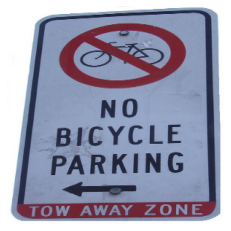

In [63]:

caption_image(img_name_vector_test[100])


<sos> bathroom sink displayed under large vanity mirror. <eos>
<sos> bathroom with sink and sink <eos>


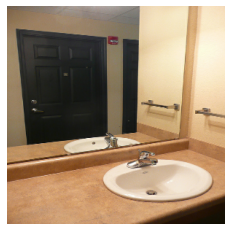

In [50]:
print(caption_test[1])
caption_image(img_name_vector_test[1])

<sos> Two teenage girls performing chores in kitchen. <eos>
<sos> woman standing in kitchen with two people in kitchen <eos>


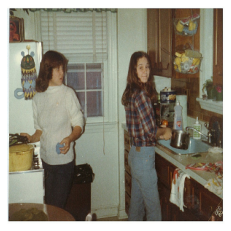

In [51]:
print(caption_test[23])
caption_image(img_name_vector_test[23])

<sos> kitchen with cabinets that have glass doors <eos>
<sos> kitchen with white appliances and white cabinets and white appliances <eos>


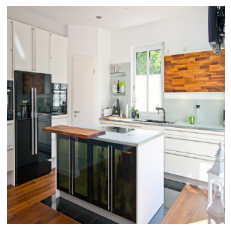

In [52]:
print(caption_test[50])
caption_image(img_name_vector_test[50])

<sos> beautiful bathroom with tiles walls and granite counter <eos>
<sos> bathroom with white sink and sink <eos>


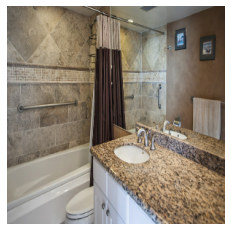

In [54]:
print(caption_test[48])
caption_image(img_name_vector_test[48])

<sos> girl riding her bike and talking on phone. <eos>
<sos> woman is riding bike <eos>


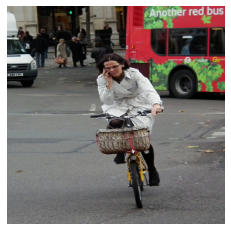

In [55]:
print(caption_test[22])
caption_image(img_name_vector_test[22])

##Saving the dictionary

In [56]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tok, handle, protocol=pickle.HIGHEST_PROTOCOL)